## Importing Libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## Uploading Cleaned dataset

In [2]:
data=pd.read_csv(r"cleaned_coverdata.csv")

In [3]:
data.head()

Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   7.862112  3.970292  1.609438                          5.560682   
1   7.859799  4.060443  1.386294                          5.365976   
2   7.939159  4.948760  2.397895                          5.598422   
3   7.932362  5.056246  2.995732                          5.497168   
4   7.861727  3.850148  1.386294                          5.043425   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                        4.997212                         6.238325   
1                        4.955827                         6.132376   
2                        5.361292                         8.065265   
3                        5.583496                         8.036573   
4                        4.990433                         6.132376   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       5.407172        5.451038       5.010635   
1       5.402677        5.463832       5.030438   
2       5.463832        5.476464       4.919981   
3       5.480639        5.476464       4.820282   
4       5.402677        5.459586       5.023881   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type_37  Soil_Type_38  \
0                            8.745284  ...      0.693147      0.693147   
1                            8.736650  ...      0.693147      0.693147   
2                            8.719807  ...      0.693147      0.693147   
3                            8.734399  ...      0.693147      0.693147   
4                            8.728102  ...      0.693147      0.693147   

   Soil_Type_39  Soil_Type_40  Cover_Type  dist_water_road_ratio  \
0      0.693147      0.693147           0               0.768228   
1      0.693147      0.693147           0               0.752341   
2      0.693147      0.693147           4               0.617568   
3      0.693147      0.693147           4               0.608324   
4      0.693147      0.693147           0               0.707117   

   dist_water_fire_ratio  hillshade_diff_morning_noon  \
0               0.570602                    -0.043867   
1               0.551111                    -0.061154   
2               0.575981                    -0.012632   
3               0.564716                     0.004175   
4               0.518439                    -0.056908   

   hillshade_diff_noon_afternoon  elevation_slope_interaction  
0                       0.440403                    12.653581  
1                       0.433394                    10.895995  
2                       0.556483                    19.037271  
3                       0.656182                    23.763233  
4                       0.435705                    10.898668  

[5 rows x 60 columns]

## Feature Normalization – Scaling to [0,1]

In [4]:
X = data.drop("Cover_Type", axis=1)
y = data["Cover_Type"]

In [5]:
scaler_mm = MinMaxScaler()
X_scaled = scaler_mm.fit_transform(X)

In [6]:
X_scaled

array([[0.21696367, 0.50884078, 0.1439477 , ..., 0.48430726, 0.49241857,
        0.14076963],
       [0.21049577, 0.53188629, 0.05623249, ..., 0.45819303, 0.48706588,
        0.05762012],
       [0.43240828, 0.75896855, 0.45388138, ..., 0.53148962, 0.58106357,
        0.44277514],
       ...,
       [0.45722024, 0.62040559, 0.375     , ..., 0.56370609, 0.55965411,
        0.36832697],
       [0.4542544 , 0.72405547, 0.375     , ..., 0.54412903, 0.56817452,
        0.36821672],
       [0.45128542, 0.74595174, 0.54867946, ..., 0.58865413, 0.63817689,
        0.53419677]], shape=(145890, 59))

## Top 15 Features Selected via Chi-Square Test

In [7]:
chi2_selector = SelectKBest(score_func=chi2, k=15)
X_selected = chi2_selector.fit_transform(X_scaled, y)
selected_columns = X.columns[chi2_selector.get_support()]

In [8]:
### Final dataset after feature selection
data = data[selected_columns.tolist() + ['Cover_Type']]
X = data.drop("Cover_Type", axis=1)
y = data["Cover_Type"]

In [9]:
data.shape

(145890, 16)

## Splitting Dataset into Training and Testing Sets (80:20)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Handling Class Imbalance using SMOTE

In [11]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [12]:
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: Cover_Type
4    82457
6    24888
0     2455
5     1728
1     1728
3     1728
2     1728
Name: count, dtype: int64
After SMOTE: Cover_Type
4    82457
5    82457
1    82457
6    82457
3    82457
0    82457
2    82457
Name: count, dtype: int64


## Feature Standardization using StandardScaler

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

## Initializing Classification Models for Comparison

In [14]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

In [15]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    results[name] = accuracy_score(y_test, y_pred)

In [17]:
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

In [18]:
results_df

Model  Accuracy
0        Random Forest  0.942354
1        Decision Tree  0.912537
4              XGBoost  0.890191
3                  KNN  0.843135
2  Logistic Regression  0.605593

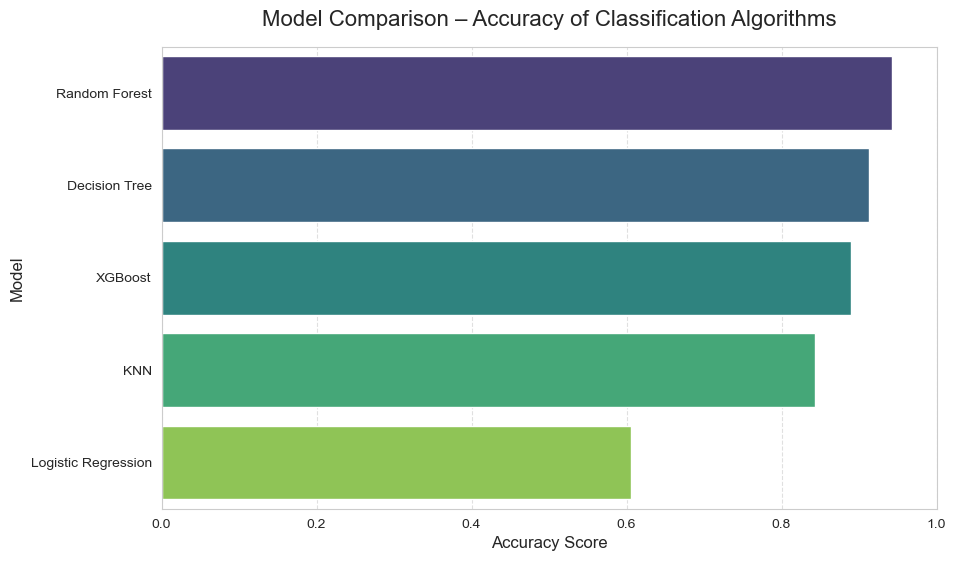

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(
    x="Accuracy", 
    y="Model", 
    data=results_df, 
    palette="viridis", 
    hue="Model", 
    dodge=False
)

plt.title("Model Comparison – Accuracy of Classification Algorithms", fontsize=16, pad=15)
plt.xlabel("Accuracy Score", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(0, 1) 
plt.legend([],[], frameon=False) 
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


##  Hyperparameter Tuning Setup for XGBoost using GridSearchCV

In [24]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [25]:
grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

In [26]:
grid_search.fit(X_train_scaled, y_train_resampled)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [20]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)


In [21]:
with open("best_covertype_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("processed_cover_le.pkl", "wb") as f:
    pickle.dump({
        "scaler": scaler,
        "selected_columns": selected_columns.tolist()
    }, f)